In [1]:
import seaborn as sbn
import os
import pairlib.scalings
import pairlib
import bioframe
import pandas as pd
import matplotlib.pyplot as plt
import pairtools
import numpy as np
from NGS import HiCTools as HT
import matplotlib.ticker as ticker
from collections import defaultdict
import matplotlib

# Define plotting parameters

In [2]:
matplotlib.rcParams.update({"pdf.fonttype": 42})

# Define functions

In [3]:
def tree():
    return defaultdict(tree)


def loadPairsChunks(path: str, chunksize: int = 100000) -> pd.DataFrame:
    """Function to load a .pairs or .pairsam file
    into a pandas dataframe iterator, which returns chunks of size chunksize"""
    # get handels for header and pairs_body
    header, pairs_body = pairtools._headerops.get_header(
            pairtools._fileio.auto_open(path, 'r'))
    # extract column names from header
    cols = pairtools._headerops.extract_column_names(header)
    # read data into dataframe
    frame = pd.read_csv(pairs_body, sep="\t", names=cols, chunksize=chunksize)
    return frame

def assignReads(dataFrameChunk, min_mapq, min_right_muts, max_wrong_muts):
    """assigns read to be either cis-sister or trans-sister or unassigned
    based on mutation rates"""
    highQ = dataFrameChunk.loc[(dataFrameChunk["mapq1"] >= min_mapq)
                               & (dataFrameChunk["mapq2"] >= min_mapq), :]
    highQ.loc[:, "size"] = highQ["pos2"] - highQ["pos1"]
    # get individual boolean arrays
    side1_has_ag = highQ["n_AG_muts_phred30_1"] >= min_right_muts
    side1_has_tc = highQ["n_TC_muts_phred30_1"] >= min_right_muts
    side2_has_ag = highQ["n_AG_muts_phred30_2"] >= min_right_muts
    side2_has_tc = highQ["n_TC_muts_phred30_1"] >= min_right_muts
    side1_no_tc = highQ["n_TC_muts_phred30_1"] <= max_wrong_muts
    side1_no_ag = highQ["n_AG_muts_phred30_1"] <= max_wrong_muts
    side2_no_tc = highQ["n_TC_muts_phred30_2"] <= max_wrong_muts
    side2_no_ag = highQ["n_AG_muts_phred30_2"] <= max_wrong_muts
    # define criterion for ref and comp
    side1_is_ref = side1_has_tc & side1_no_ag
    side1_is_comp = side1_has_ag & side1_no_tc
    side2_is_ref = side2_has_tc & side2_no_ag
    side2_is_comp = side2_has_ag & side2_no_tc
    # bin into cisref and ciscomp
    is_cis_ref = side1_is_ref & side2_is_ref
    is_cis_comp = side1_is_comp & side2_is_comp
    is_trans_ref_comp = side1_is_ref & side2_is_comp
    is_trans_comp_ref = side1_is_comp & side2_is_ref
    # assign cis and trans
    is_cis = is_cis_ref | is_cis_comp
    is_trans = is_trans_ref_comp | is_trans_comp_ref
    # subset dataframe
    cisFrame = highQ.loc[is_cis, :]
    transFrame = highQ.loc[is_trans, :]
    # double
    double = pd.concat((cisFrame, transFrame)).drop_duplicates()
    return {"cis": cisFrame, "trans": transFrame, "total": len(dataFrameChunk), "double": len(double)}

# set wd

In [4]:
os.chdir("/groups/gerlich/experiments/Experiments_004700/004727/")

# define Hi-C paths

In [5]:
basePath = "/groups/gerlich/experiments/Experiments_004600/004615/Sequencing_data/Novaseq/pairs/"
barcodes=["AGTCAA"]
hiCPath = {}
for index, barcode in enumerate(barcodes, start=1):
    tempFile = f"{barcode}.dedup.s4t.pairsam.gz"
    hiCPath[f"rep{index}"] = os.path.join(basePath, tempFile)

In [6]:
hiCPath

{'rep1': '/groups/gerlich/experiments/Experiments_004600/004615/Sequencing_data/Novaseq/pairs/AGTCAA.dedup.s4t.pairsam.gz'}

# calculate reads

In [7]:
# fix paramters that are not variable
mapth = 30
max_wrong_muts = 0

# initialize result data structures
doubleDict = tree()

for rep in hiCPath:
    pairIterator = loadPairsChunks(hiCPath[rep], chunksize=1000000)
    tempFrame = next(pairIterator)
    for minTH in range(1, 5):
        tempResult = assignReads(tempFrame, mapth, minTH, max_wrong_muts)
        cis1kb = tempResult["cis"].loc[tempResult["cis"]["size"] < 1000, :]
        trans1kb = tempResult["trans"].loc[tempResult["trans"]["size"] < 1000, :]
        doubleDict[rep][minTH] = (tempResult["double"]/tempResult["total"]) * 100

/home/anaconda3/envs/ngs_base/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/anaconda3/envs/ngs_base/lib/python3.7/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
doubleFrame = pd.DataFrame(doubleDict)
doubleFrame

,rep1
1,2.4222
2,0.1186
3,0.0287
4,0.0124


In [9]:
moltenDouble = pd.melt(doubleFrame.reset_index(), id_vars="index").rename(columns={"index": "muts"})
moltenDouble = moltenDouble.sort_values(by="muts", ascending=True)

In [10]:
means = moltenDouble.groupby("muts").agg({"value": np.mean}).reset_index()
error = moltenDouble.groupby("muts").agg({"value": np.std}).reset_index()

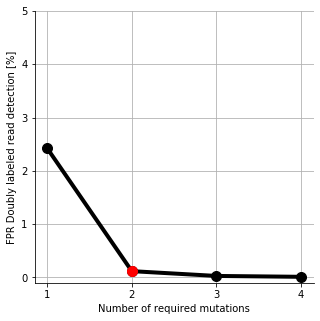

In [11]:
f, ax = plt.subplots()
ax.plot(means.loc[:, "muts"],means.loc[:, "value"],
       color="black", lw=4)
ax.errorbar(means.loc[:, "muts"], means.loc[:, "value"], error.loc[:, "value"], fmt="o",
       color="black", markersize=10)
ax.errorbar(means.loc[means["muts"] == 2, "muts"], means.loc[means["muts"] == 2, "value"], error.loc[means["muts"] == 2, "value"], fmt="o",
       color="red", markersize=10)
#sbn.barplot(x="variable", y="value_log10", data=molten.loc[molten["MappingQuality cut-off"] == 30, :], color="black")
ax.grid(True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
majors = ["", "1", "2", "3", "4"]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(majors))
ax.set(xlabel="Number of required mutations", ylabel="FPR Doubly labeled read detection [%]", ylim=(-0.1, 5))
sbn.despine()
f.set_size_inches(5, 5)
plt.show()

## save result

In [12]:
resultsdir = "/groups/gerlich/experiments/Experiments_004700/004727/Results/"
f.savefig(os.path.join(resultsdir, "Doubly_labeled_fpr_norelease.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "Doubly_labeled_fpr_norelease.pdf"), bbox_inches="tight")